#################################################### 
# 读取 NetCDF 格式的气候数据, 以及简单的绘图展示
####################################################

# import libraries 




In [77]:
import pandas as pd 
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt

# Define inpath for the file 

In [78]:
# nc文件路径，示例
nc_file_path = './TEMP/temp_CMFD_V0200_B-01_03hr_010deg_197501.nc'
# domain file, 研究区域文件, 湖南洞庭湖地区
domain_file_path = './domain.nc'

# read CMFD data (China)

In [79]:
# read NetCDF file using xarray 
ds = xr.open_dataset(nc_file_path)

# Extract latitude and longitude, 数据的坐标
lats = ds['lat'].values
lons = ds['lon'].values

# Print dataset information
print(ds)
print("Latitude range:", lats.min(), "to", lats.max())
print("Longitude range:", lons.min(), "to", lons.max())

<xarray.Dataset> Size: 278MB
Dimensions:  (lat: 400, lon: 700, time: 248)
Coordinates:
  * lat      (lat) float32 2kB 15.05 15.15 15.25 15.35 ... 54.75 54.85 54.95
  * lon      (lon) float32 3kB 70.05 70.15 70.25 70.35 ... 139.8 139.9 139.9
  * time     (time) datetime64[ns] 2kB 1975-01-01 ... 1975-01-31T21:00:00
Data variables:
    temp     (time, lat, lon) float32 278MB ...
Attributes:
    Conventions:  CF-1.0
    title:        3-hourly near-surface air temperature from the China Meteor...
    history:      Created at 2023-08-08 14:12:54 UTC by the Meteorological Da...
    source:       Meteorological Data Fusion System (Version: 01.02.0280)
    institution:  Institute of Tibetan Plateau Research, Chinese Academy of S...
    description:  Data from China Meteorological Forcing Dataset (Version: 02...
    references:   He, J., K. Yang, X. Li, W. Tang, C. Shao, Y. Jiang, B. Ding...
Latitude range: 15.05 to 54.95
Longitude range: 70.05 to 139.95


# plot China climate (e.g., temp)

Variable 'temp' data shape: (248, 400, 700)


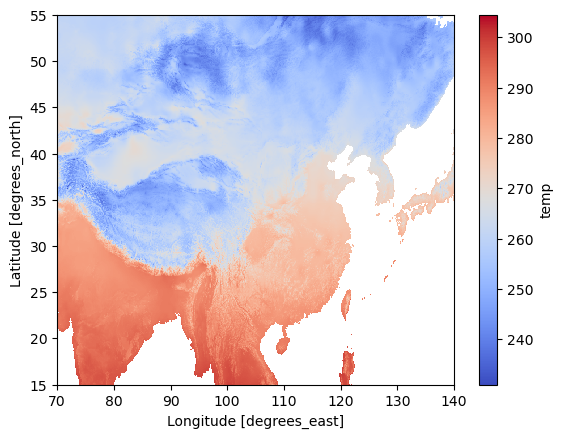

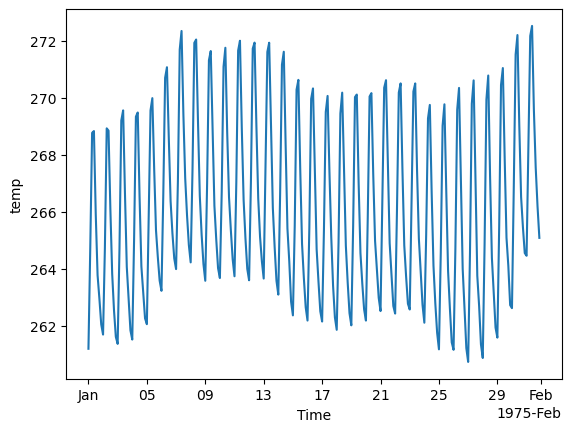

In [80]:
# Extract variable data (temp)
variable_temp = ds['temp']
print("Variable 'temp' data shape:", variable_temp.shape)

# 对数据变量进行时间维度的平均，并进行空间分布展示
variable_temp.mean(dim='time').plot(cmap='coolwarm')
plt.show()

# 对数据变量进行空间范围的平均，并进行时间动态展示
variable_temp.mean(dim=['lat', 'lon']).plot()
plt.show()

# read Study domain data (mask)

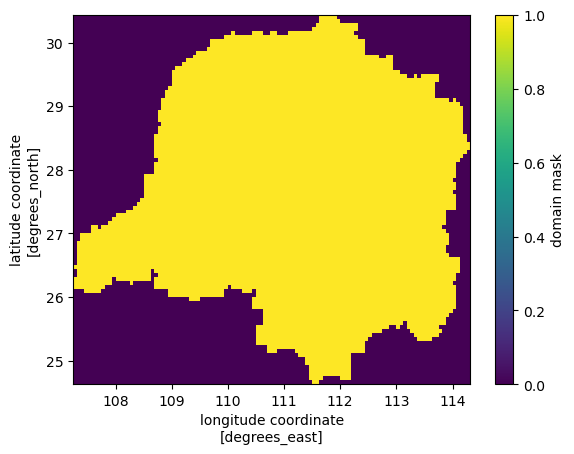

In [81]:
domain = xr.open_dataset(domain_file_path)
mask = domain['mask']    # Dongting Lake Basin

# 研究区域的经纬度坐标
mask_lat = domain['lat'].values
mask_lon = domain['lon'].values

mask.plot()   # only mask = 1 is valid area

# plot Study domain climate (Dongting/Hunan)

## get the masked data 

1. resample/interpolate the CMFD dataset to same lontitude/latitude coords with the Study domain


In [82]:
# 掩膜所在的研究区域
# 1. Interpolate spatially to VIC grid, 空间插值，以达到相同的坐标
ds_interp = ds.interp(lat=mask_lat, lon=mask_lon, method='linear')
variable_temp_interp = ds_interp['temp']

## compare the data before and after the interpolate/resample 

In [83]:
# spatial boudary of the Dongting/Hunan region
lon_min = mask_lon.min()
lon_max = mask_lon.max()
lat_min = mask_lat.min()
lat_max = mask_lat.max()

# before the interpolate/resample
variable_temp_dongting = variable_temp.sel(lat=slice(lat_min, lat_max), lon=slice(lon_min, lon_max))
# rename the variable for clarity
variable_temp_dongting.name = 'temp'

# after the interpolate/resample
variable_temp_interp_dongting = variable_temp_interp.sel(lat=slice(lat_min, lat_max), lon=slice(lon_min, lon_max))
# rename the variable for clarity
variable_temp_interp_dongting.name = 'temp_interp'

# concatenate the two dataaarray along a new dimension
temp_dongting = xr.concat([variable_temp_dongting, variable_temp_interp_dongting], dim='variable')
temp_dongting.coords['variable'] = ['Temp Before', 'Temp After']

In [84]:
variable_temp_interp_dongting.shape, variable_temp_dongting.shape

((248, 93, 113), (248, 57, 70))

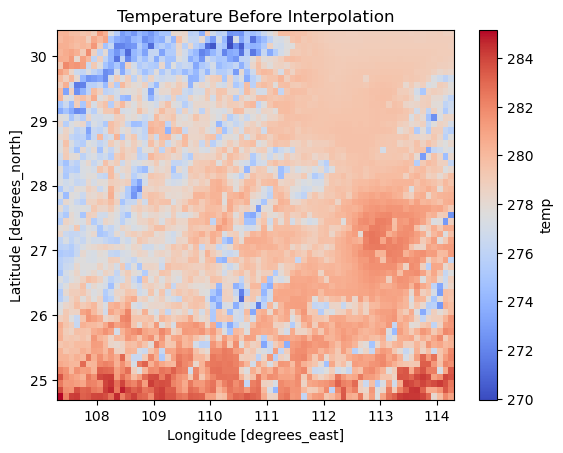

In [85]:
variable_temp_dongting.mean('time').plot(cmap='coolwarm')
plt.title('Temperature Before Interpolation')
plt.show()

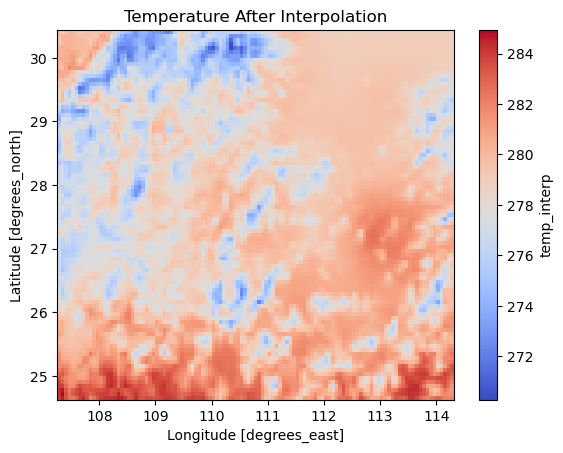

In [86]:
variable_temp_interp_dongting.mean('time').plot(cmap='coolwarm')
plt.title('Temperature After Interpolation')
plt.show()

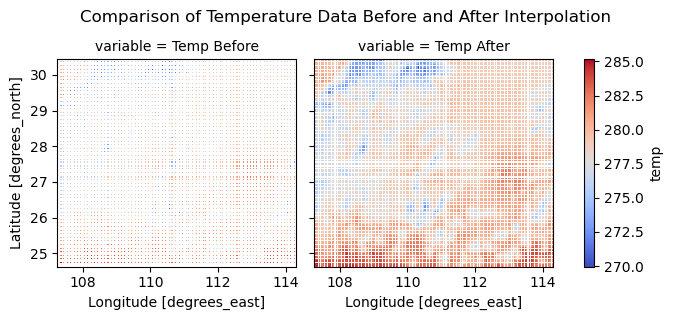

In [87]:
# plotting the comparison
temp_dongting.mean('time').plot(col='variable', col_wrap=2, cmap='coolwarm')
plt.suptitle('Comparison of Temperature Data Before and After Interpolation',
             y=1.05)
plt.savefig('temp_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

2. mask the CMFD data to align with the Dongting/Hunan region

In [88]:
ds_mask = variable_temp_interp_dongting.where(mask==1, drop=True)  # Masking the data based on the domain mask

# plot Study domain climate (e.g., temp)

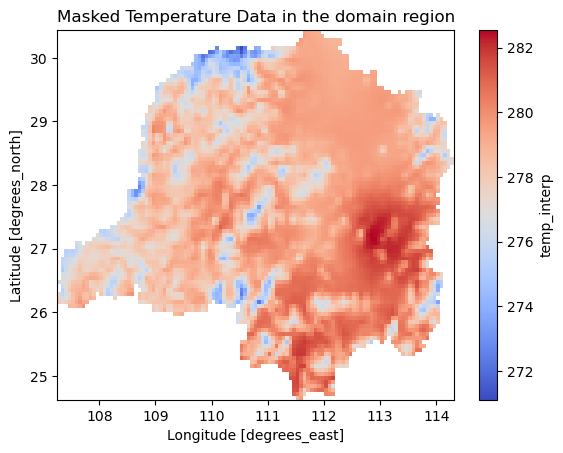

In [89]:
ds_mask.mean('time').plot(cmap='coolwarm')
plt.title('Masked Temperature Data in the domain region')
plt.show()

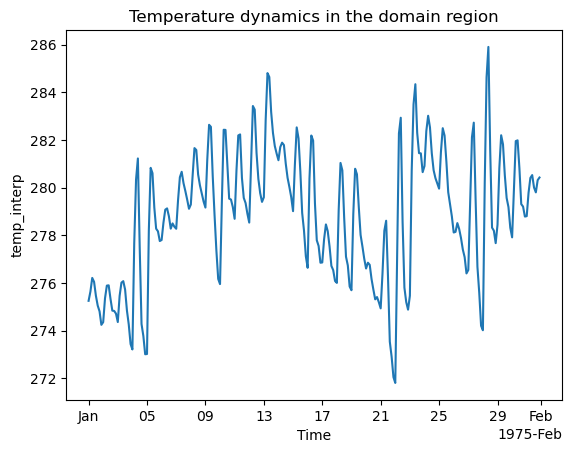

In [90]:

# 对数据变量进行空间范围的平均，并进行时间动态展示
ds_mask.mean(dim=['lat', 'lon']).plot()
plt.title('Temperature dynamics in the domain region')
plt.show()